# Algoritmo de Metrópolis - Parte 2

## Imports

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from tqdm.notebook import tqdm
from typing import List,Callable,Dict,Union
import itertools

## Funções e Classes

### Classe da Grid do Modelo de Ising

In [2]:
class IsingGrid:
    """
    Classe que implementa uma grid 2D do modelo de Ising como um vetor 1D. 
    (Essencialmente um wrapper do np.array)
    """
    def __init__(self,n_rows:int,n_cols:int,is_torus:bool=True,
                 J_constant:float=1)->None:
        self.n_rows=n_rows
        self.n_cols=n_cols
        self.num_cells = n_rows*n_cols
        self.J_constant=J_constant
        self.is_torus = is_torus
        self.array = np.zeros(self.num_cells)
        
    def init_randint_array(self,seed:int,low:int=0,
                           high:int=2)->None:
        """
        Inicializa uma grid aleatória
        """
        np.random.seed(seed)
        self.array = np.random.randint(low=low,high=high,size=self.num_cells)
        self.array[np.where(self.array == 0)[0]] = -1
        
    def __check_input(self,row:int,col:int)->None:
        """
        Checa se o input é válido
        """
        if row >= self.n_rows or col >= self.n_cols:
            raise ValueError(f"Valor inválido para column/row ({row}/{self.n_rows},{col}/{self.n_cols})")
    
    def cell_to_row_col(self,cell:int)->Union[int,int]:
        """
        Converte um índice de célula para um par (i,j) da grid
        """
        curr_row = cell // self.n_cols
        curr_col = cell % self.n_cols

        return curr_row,curr_col

    def print_grid(self)->None:
        """
        Método print da grid
        """
        for i in range(self.n_rows):
            print(self.array[i*self.n_rows:(i+1)*self.n_rows])

    def __next__(self):
        """
        Método next
        """
        if self.iter_counter < self.num_cells:
            curr_row,curr_col = self.cell_to_row_col(self.iter_counter)
            
            self.iter_counter += 1
            
            return curr_row,curr_col
        else:
            raise StopIteration
            
    def __iter__(self):
        """
        Método iter
        """
        self.iter_counter = 0
        return self

    def copy(self):
        """
        Método que cria uma cópia do objeto
        """
        grid_copy = IsingGrid(self.n_rows,self.n_cols)
        grid_copy.array = self.array.copy()
        return grid_copy
    
    def get_cell_spin(self,row:int,col:int)->int:
        """
        Método get do spin
        """
        tgt_row = row
        tgt_col = col
        
        if not self.is_torus:
            self.__check_input(row,col)
        else:
            if row < 0:
                tgt_row = self.n_rows-1
            elif row >= self.n_rows:
                tgt_row = 0
            
            if col < 0:
                tgt_col = self.n_cols - 1 
            elif col >= self.n_cols:
                tgt_col = 0 
            
        tgt_cell = self.n_cols * tgt_row + tgt_col
        return self.array[tgt_cell]
        
    def set_cell_spin(self,value:int,row:int,col:int)->None:
        """
        Método set do spin
        """
        if not self.is_torus:
            self.check_input(row,col)
        
        tgt_cell = self.n_cols * row + col
        self.array[tgt_cell]=value
            
    def compute_cell_partial_energy(self,row:int,col:int,
                                    flip:bool=False) -> float:
        """
        Método que computa a energia parcial de uma célula
        """
        curr_cell_spin = self.get_cell_spin(row,col)
        if flip:
            curr_cell_spin = -1 * curr_cell_spin

        up_neighbor_energy = curr_cell_spin*self.get_cell_spin(row-1,col)
        down_neighbor_energy = curr_cell_spin*self.get_cell_spin(row+1,col)
        left_neighbor_energy = curr_cell_spin*self.get_cell_spin(row,col-1)
        right_neighbor_energy = curr_cell_spin*self.get_cell_spin(row,col+1)

        partial_energy = up_neighbor_energy + down_neighbor_energy + left_neighbor_energy + right_neighbor_energy

        return partial_energy
    
    def compute_cell_neighbor_energy(self,row:int,col:int)->float:
        input_cell_spin = self.get_cell_spin(row,col)
        
        neighbors_energy = 0
        if input_cell_spin == -1:
            neighbors_energy = self.compute_cell_partial_energy(row,col,flip=True)
        else:
            neighbors_energy = self.compute_cell_partial_energy(row,col,flip=False)
        return neighbors_energy

    def compute_hamiltonian(self) -> float:
        """
        Método que computa o hamiltoniano da grid
        """
        hamiltonian = 0
        for row,col in iter(self):
            hamiltonian += self.compute_cell_partial_energy(row,col)
        return self.J_constant * hamiltonian
    

### Funções do algoritmo de Metropolis

In [3]:
def create_score_table(beta:int,
                       possible_energy_values:list=[-8,-4,0,4,8]) -> dict:
    """
    Cria a tabela(dicionário) de probabilidades para consulta
    """
    score_table = {val:np.exp((-val)*beta) for val in possible_energy_values}
    return score_table

def metropolis_monte_carlo_step(ising_grid:IsingGrid,score_table:dict,
                                     energy:int,magnetization:int,
                                     metropolis_seed:int=1234)->Union[int,int]:
    """
    Faz um passo de monte carlo de forma sequencial, i.e., percorre todas as celulas sequencialmente
    """
    energy = 0
    magnetization = 0
    for start_cell_row,start_cell_col in iter(ising_grid):
        start_cell_spin = ising_grid.get_cell_spin(start_cell_row,start_cell_col)
        
        neighbors_energy = ising_grid.compute_cell_neighbor_energy(start_cell_row,start_cell_col)

        energy_diff = 2*start_cell_spin*neighbors_energy
        energy_score = score_table[int(energy_diff)]
        
        r_value = np.random.uniform(0,1)
        if r_value <= energy_score:
            energy += energy_diff
            magnetization -= 2*start_cell_spin
            
            ising_grid.set_cell_spin(-1 * start_cell_spin,start_cell_row,start_cell_col)
    return energy,magnetization

def metropolis_monte_carlo(ising_grid:IsingGrid,metropolis_monte_carlo_step_func:Callable,
                           score_table:dict,num_monte_carlo_steps:int=1000,
                           metropolis_seed:int=1234)->Union[List[int],List[int]]:
    """
    Realiza num_monte_carlo_steps passos de monte carlo do algoritmo de metropolis
    """
    energy = ising_grid.compute_hamiltonian()
    magnetization = ising_grid.array.sum()
    
    energy_history = [energy]
    magnetization_history = [magnetization]
    
    for mc_step in tqdm(range(num_monte_carlo_steps)):
        curr_energy,curr_magnetization = metropolis_monte_carlo_step_func(ising_grid,score_table,
                                                                          energy,magnetization,
                                                                          metropolis_seed)
        energy += curr_energy
        magnetization += curr_magnetization
        
        energy_history.append(energy)
        magnetization_history.append(magnetization)
        
    return energy_history,magnetization_history

### Funções para auxiliar nos experimentos

In [9]:
def compute_quantity_means(quantity_hist:np.array,num_boxes:int):
    return np.array([box_slice.mean() for box_slice in np.split(quantity_hist,num_boxes)])

def compute_quantity_variances(quantity_hist:np.array,num_boxes:int,weight_factor:float):
    quantity_variances = [weight_factor * box_slice.var() 
                          for box_slice in np.split(quantity_hist,num_boxes)]
    return np.array(quantity_variances)
    
def compute_statistical_error(quantity_variances:np.array):
    num_samples = len(quantity_variances)
    
    quantity_mean_variance = np.mean(quantity_variances)
    denominator = num_samples*(num_samples-1)
    numerator = np.sum([(quantity_mean_variance - ith_variance)**2 for ith_variance in quantity_variances])
    
    return np.sqrt(numerator/denominator)
    
def compute_experiment_results(termalized_energy_hist:np.array,termalized_magnetization_hist:np.array,
                               num_boxes:int,steps_per_box:int,num_cells:int):
    per_spin_weight = 1/num_cells
    # Estatísticas relacionadas a energia
    energy_means = compute_quantity_means(termalized_energy_hist,num_boxes)
    ## Energia por spin
    energy_per_spin_means = per_spin_weight * energy_means
    energy_per_spin_error = compute_statistical_error(energy_per_spin_means)
    ## Calor específico
    specific_heat_weight = (beta**2)/num_cells
    specific_heats = compute_quantity_variances(termalized_energy_hist,num_boxes,specific_heat_weight)
    specific_heat_error = compute_statistical_error(specific_heats)

    # Estatísticas relacionadas a magnetização
    magnetization_means = compute_quantity_means(termalized_magnetization_hist,num_boxes)
    ## Magnetização por spin em módulo
    magnetization_per_spin_means = per_spin_weight * magnetization_means
    magnetization_per_spin_error = compute_statistical_error(magnetization_per_spin_means)
    ## Susceptibilidade magnética
    magnetic_susceptibility_weight = beta/num_cells
    magnetic_susceptibilities = compute_quantity_variances(termalized_magnetization_hist,num_boxes,magnetic_susceptibility_weight)
    magnetic_susceptibility_error = compute_statistical_error(magnetic_susceptibilities)
    
    return [(np.mean(energy_per_spin_means),energy_per_spin_error),
            (np.mean(specific_heats),specific_heat_error),
            (np.mean(magnetization_per_spin_means),magnetization_per_spin_error),
            (np.mean(magnetic_susceptibilities),magnetic_susceptibility_error)]

def plot_results_with_errorbar(experiment_results:list,size:int,
                               title:str,xtickslabels:np.ndarray=None,xlabel:str=None):
    fig,axs = plt.subplots(2,2,figsize=(12,10),sharex=True)
    ax_col = 0
    ax_row = 0
    
    if xtickslabels is not None:
        axs[0,0].set_xticks(np.arange(0,len(xtickslabels),1))
        axs[0,0].set_xticklabels(xtickslabels)
    for quantity_name,quantity_means,quantity_errors in experiment_results:
        if ax_row >= len(axs):
            ax_col += 1
            ax_row = 0
            
        fig.suptitle(title,y=0.92)
        num_samples = len(quantity_means)
        x = np.arange(0,num_samples,1)
        axs[ax_row,ax_col].plot(x,quantity_means,'-bo')
        axs[ax_row,ax_col].errorbar(x,quantity_means,yerr=quantity_errors,ecolor='r',label=f"Error",
                                    capsize=10,elinewidth=2,markersize='10')
        axs[ax_row,ax_col].set_xticks(x)
        axs[ax_row,ax_col].set_ylabel(quantity_name)
        axs[ax_row,ax_col].legend()
        ax_row += 1
        if ax_row == 1:
            axs[ax_row,ax_col].set_xlabel(xlabel)
            
    # plt.show()

## Experimentos

In [10]:
# Constantes
boltzmann_constant = 1
J_constant = 1
possible_energy_values = [-8,-4,0,4,8]

In [11]:
# Parâmetros do experimento
temperatures = np.arange(3,1.9,-0.1)
sizes = [18,24,36,48]

num_monte_carlo_steps = 110000 # 100000 + 10000
metropolis_seed = 1234
grid_seed = 2021

nsteps_to_ignore = 10001 # Número de passos até termalizar
num_boxes = 10 # número de caixas
steps_per_box = int((num_monte_carlo_steps-nsteps_to_ignore)/num_boxes)+1

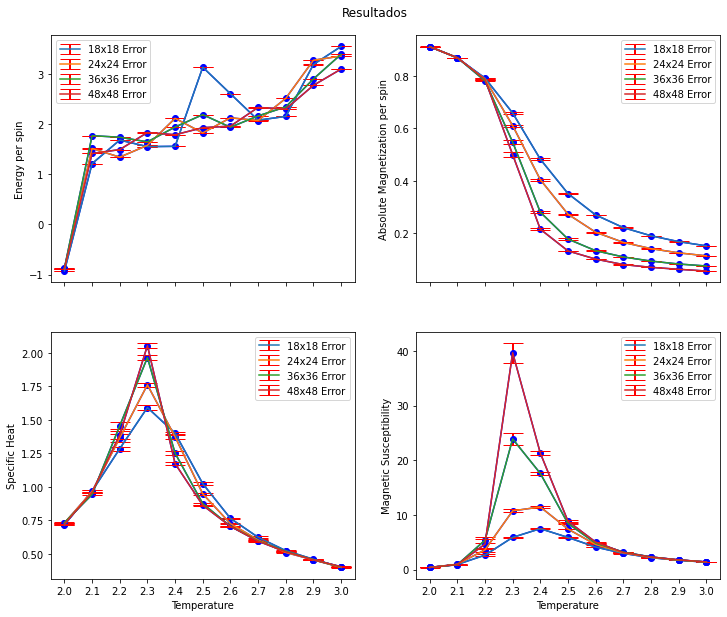

In [12]:
# Loop do experimento 
xtickslabels=np.round(temperatures[::-1],2)
xlabel='Temperature'

fig,axs = plt.subplots(2,2,figsize=(12,10),sharex=True)
fig.suptitle('Resultados',y=0.92)

if xtickslabels is not None:
    axs[0,0].set_xticks(np.arange(0,len(xtickslabels),1))
    axs[0,0].set_xticklabels(xtickslabels)
    
for size in sizes:
    n_rows=n_cols=size
    ising_grid = IsingGrid(n_rows,n_cols,J_constant=J_constant)
    ising_grid.init_randint_array(grid_seed)
    num_cells = ising_grid.num_cells
    
    energies_per_spin = []
    energies_per_spin_errors = []
    specific_heats = []
    specific_heats_errors = []
    
    magnetizations_per_spin = []
    magnetizations_per_spin_errors = []
    magnetic_susceptibilities = []
    magnetic_susceptibilities_errors = []
    
    
    for temperature in temperatures:
        filename = f'energy_mag_hist_{np.round(temperature,2)}_{size}'
        
        # Inicializa a tabela de scores pré-computadas
        beta = 1/(boltzmann_constant * temperature)
        score_table = create_score_table(beta,possible_energy_values)

        # Realiza a simulação (ou carrega dados salvos)
        if filename+'.npy' in os.listdir():
            stats_hist = np.load(filename + '.npy')
            energy_hist = stats_hist[0]
            magnetization_hist = stats_hist[1]
            ising_grid.array = np.load(f'ising_grid_state_{np.round(temperature,2)}_{size}.npy')
        else:        
            energy_hist,magnetization_hist = metropolis_monte_carlo(ising_grid,metropolis_monte_carlo_step,
                                                                    score_table,num_monte_carlo_steps,metropolis_seed)
            np.save(filename + '.npy',[energy_hist,magnetization_hist])
            np.save(f'ising_grid_state_{np.round(temperature,2)}_{size}.npy',ising_grid.array)
        
        termalized_energy_hist = energy_hist[nsteps_to_ignore:]
        termalized_magnetization_hist = np.abs(magnetization_hist[nsteps_to_ignore:]) # take the absolute value

        energy_results,specific_heat_results,magnetization_results,susceptibility_results = compute_experiment_results(termalized_energy_hist,
                                                                                                 termalized_magnetization_hist,
                                                                                                 num_boxes,steps_per_box,num_cells)
        
        energies_per_spin.append(energy_results[0])
        energies_per_spin_errors.append(energy_results[1])
        specific_heats.append(specific_heat_results[0])
        specific_heats_errors.append(specific_heat_results[1])
        
        magnetizations_per_spin.append(magnetization_results[0])
        magnetizations_per_spin_errors.append(magnetization_results[1])
        magnetic_susceptibilities.append(susceptibility_results[0])
        magnetic_susceptibilities_errors.append(susceptibility_results[1])
    
    experiment_names = ["Energy per spin","Specific Heat","Absolute Magnetization per spin","Magnetic Susceptibility"]
    experiment_results = [("Energy per spin",energies_per_spin,energies_per_spin_errors),
                          ("Specific Heat",specific_heats[::-1],specific_heats_errors[::-1]),
                          ("Absolute Magnetization per spin",magnetizations_per_spin[::-1],magnetizations_per_spin_errors[::-1]),
                          ("Magnetic Susceptibility",magnetic_susceptibilities[::-1],magnetic_susceptibilities_errors[::-1])]
    
    ax_col = 0
    ax_row = 0
    for quantity_name,quantity_means,quantity_errors in experiment_results:
        if ax_row >= len(axs):
            ax_col += 1
            ax_row = 0
            
        num_samples = len(quantity_means)
        x = np.arange(0,num_samples,1)
        axs[ax_row,ax_col].plot(x,quantity_means,'-bo')
        axs[ax_row,ax_col].errorbar(x,quantity_means,yerr=quantity_errors,ecolor='r',label=f"{size}x{size} Error",
                                    capsize=10,elinewidth=2,markersize='10')
        axs[ax_row,ax_col].set_xticks(x)
        axs[ax_row,ax_col].set_ylabel(quantity_name)
        axs[ax_row,ax_col].legend()
        ax_row += 1
        if ax_row == 1:
            axs[ax_row,ax_col].set_xlabel(xlabel)
    
plt.show()

*Observações*

- A análise dos gráficos acima nos permite chegar a algumas conclusões acerca do que se pode esperar para tamanhos maiores de grid. Tanto o calor específico quanto a susceptibilidade magnética apresentam picos em torno da temperatura 2.3, i.e., são crescentes até tal temperatura e depois decrescem, tendendo aos poucos a valores próximos de 0. Além disso, o valor da energia por spin aumenta com a temperatura. O valor absoluto da magnetização por spin parece convergir para valores próximos de zero com o aumento da temperatura, mas note que tal valor se aproxima mais ainda de zero para grid com tamanho maior. Portanto, pode-se esperar que para um sistema infinito, a magnetização tenda a zero, a susceptibilidade magnética e o calor específico tendam a valores entre 0 e 1.
- De forma geral, a temperatura 2.3 também representa uma mudança interessante nos valores médios, e principalmente devido aos gráficos do calor específico e da susceptibilidade magnética, podemos observar que provavelmente tal temperatura indica uma mudança de fase.

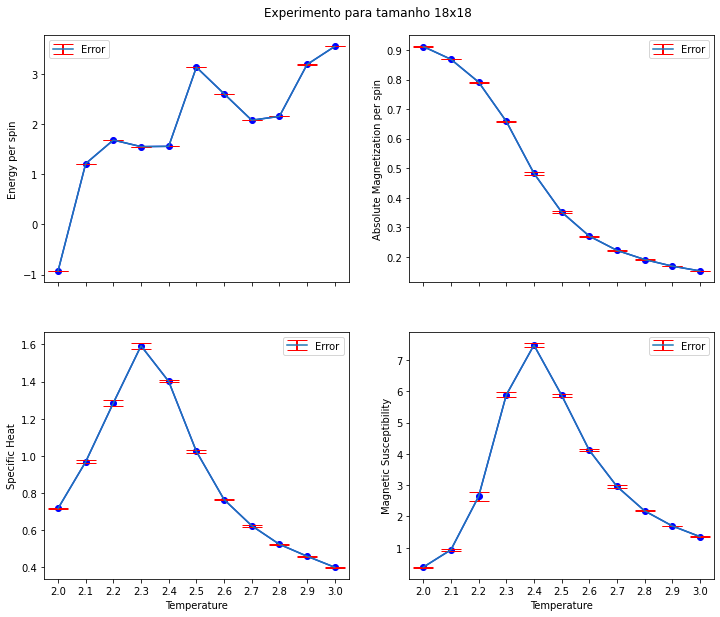

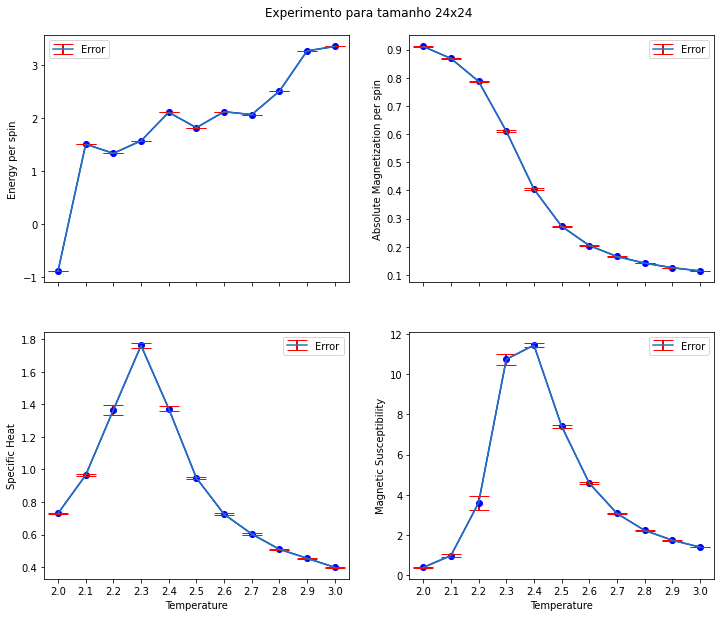

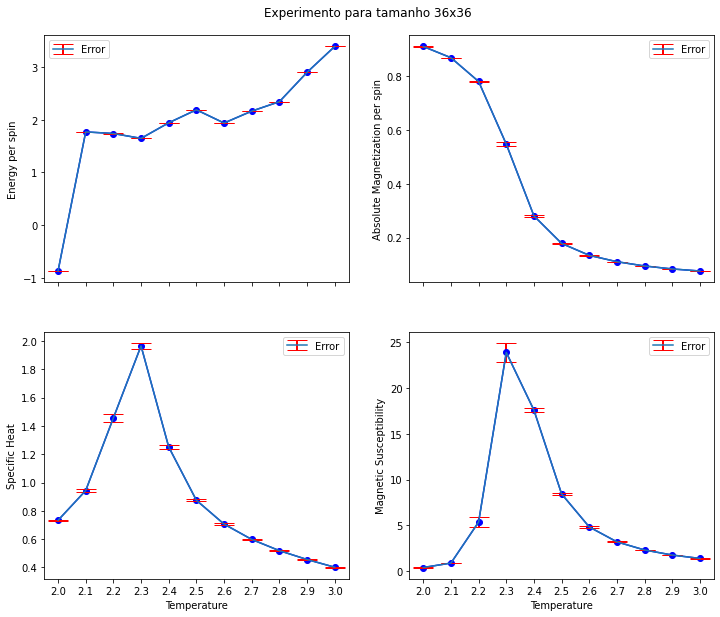

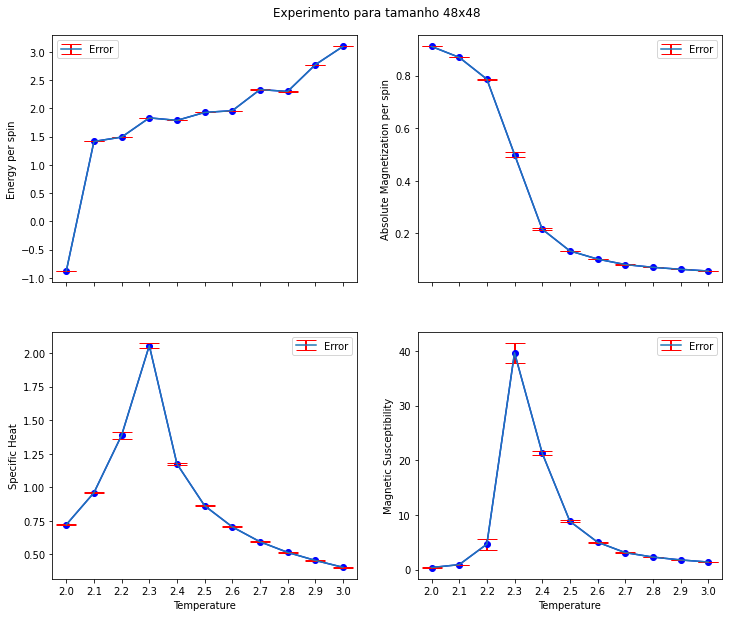

In [13]:
# Loop do experimento   
for size in sizes:
    n_rows=n_cols=size
    ising_grid = IsingGrid(n_rows,n_cols,J_constant=J_constant)
    ising_grid.init_randint_array(grid_seed)
    num_cells = ising_grid.num_cells
    
    energies_per_spin = []
    energies_per_spin_errors = []
    specific_heats = []
    specific_heats_errors = []
    
    magnetizations_per_spin = []
    magnetizations_per_spin_errors = []
    magnetic_susceptibilities = []
    magnetic_susceptibilities_errors = []
    
    
    for temperature in temperatures:
        filename = f'energy_mag_hist_{np.round(temperature,2)}_{size}'
        
        # Inicializa a tabela de scores pré-computadas
        beta = 1/(boltzmann_constant * temperature)
        score_table = create_score_table(beta,possible_energy_values)

        # Realiza a simulação (ou carrega dados salvos)
        if filename+'.npy' in os.listdir():
            stats_hist = np.load(filename + '.npy')
            energy_hist = stats_hist[0]
            magnetization_hist = stats_hist[1]
            ising_grid.array = np.load(f'ising_grid_state_{np.round(temperature,2)}_{size}.npy')
        else:        
            energy_hist,magnetization_hist = metropolis_monte_carlo(ising_grid,metropolis_monte_carlo_step,
                                                                    score_table,num_monte_carlo_steps,metropolis_seed)
            np.save(filename + '.npy',[energy_hist,magnetization_hist])
            np.save(f'ising_grid_state_{np.round(temperature,2)}_{size}.npy',ising_grid.array)
        
        termalized_energy_hist = energy_hist[nsteps_to_ignore:]
        termalized_magnetization_hist = np.abs(magnetization_hist[nsteps_to_ignore:]) # take the absolute value

        energy_results,specific_heat_results,magnetization_results,susceptibility_results = compute_experiment_results(termalized_energy_hist,
                                                                                                 termalized_magnetization_hist,
                                                                                                 num_boxes,steps_per_box,num_cells)
        
        energies_per_spin.append(energy_results[0])
        energies_per_spin_errors.append(energy_results[1])
        specific_heats.append(specific_heat_results[0])
        specific_heats_errors.append(specific_heat_results[1])
        
        magnetizations_per_spin.append(magnetization_results[0])
        magnetizations_per_spin_errors.append(magnetization_results[1])
        magnetic_susceptibilities.append(susceptibility_results[0])
        magnetic_susceptibilities_errors.append(susceptibility_results[1])
    
    experiment_names = ["Energy per spin","Specific Heat","Absolute Magnetization per spin","Magnetic Susceptibility"]
    experiment_results = [("Energy per spin",energies_per_spin,energies_per_spin_errors),
                          ("Specific Heat",specific_heats[::-1],specific_heats_errors[::-1]),
                          ("Absolute Magnetization per spin",magnetizations_per_spin[::-1],magnetizations_per_spin_errors[::-1]),
                          ("Magnetic Susceptibility",magnetic_susceptibilities[::-1],magnetic_susceptibilities_errors[::-1])]
    
    
    plot_results_with_errorbar(experiment_results,size,f"Experimento para tamanho {size}x{size}",
                               xtickslabels=np.round(temperatures[::-1],2),xlabel='Temperature')

*Observações*

- Ao analisarmos os gráficos separadamente para cada tamanho de grid, podemos observar que temperaturas entre 2.2-2.4 apresentam erros estatísticos maiores. O valor dos erros varia de acordo com o tamanho da grid como esperado, mas certamente isso pode ser mais um indício de uma potencial transição de fase nessas temperaturas, tendo em vista que uma mudança brusca no comportamento geral do sistema pode explicar o maior erro nas medições.